In [1]:
from __future__ import print_function, division

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# image imports
from skimage import io, transform
from PIL import Image

# general imports
import os
import time
from shutil import copyfile
from shutil import rmtree

# data science imports
import pandas as pd
import numpy as np
import csv

import cxr_dataset as CXR
import eval_model as E

from __future__ import print_function, division
from datetime import datetime
# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import cxr_dataset as CXR
import eval_model as E

import cropping as C
import cropping_for_vis as C_vis

import matplotlib.pyplot as plt
import cv2
import numpy as np

from scipy.ndimage.measurements import find_objects
from scipy import ndimage
from matplotlib.pyplot import imshow, figure
import matplotlib.pyplot as plt
print('Dependencies loaded')

Dependencies loaded


In [2]:
global_model = models.densenet121(pretrained=True)
num_ftrs = global_model.classifier.in_features
# add final layer with # outputs in same dimension of labels with sigmoid
# activation
global_model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 14), nn.Sigmoid())

# put model on GPU
global_model = global_model.cuda()

local_model = models.densenet121(pretrained=True)
num_ftrs = local_model.classifier.in_features
# add final layer with # outputs in same dimension of labels with sigmoid
# activation
local_model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 14), nn.Sigmoid())

# put model on GPU
local_model = local_model.cuda()

fusion_model = nn.Sequential(nn.Linear(2048,14), nn.Sigmoid())
fusion_model = fusion_model.cuda()


global_model.load_state_dict(torch.load('state_dict_global'))
local_model.load_state_dict(torch.load('state_dict_local'))
fusion_model.load_state_dict(torch.load('state_dict_fusion'))

print('Models defined and state dictionaries loaded.')

C:\Users\vijay\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Models defined and state dictionaries loaded.


We will now see the heatmap and the cropping. The next cell displays the original x-ray image, the heatmap, the mask, and the cropped image. You can run this cell multiple times to generate new images.

C:\Users\vijay\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Cropped')

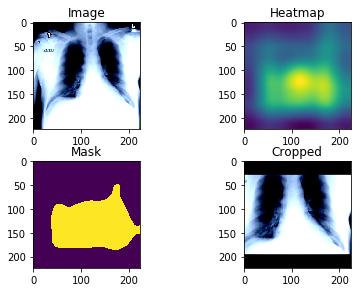

In [32]:

thresh = 0.5 # Change this value to change the threshold in the cropping.

PATH_TO_IMAGES = 'starter_images'
STARTER_IMAGES = True

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]



data_transform = transforms.Compose([
    transforms.Scale(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


finding = 'any'

dataset = CXR.CXRDataset(
    path_to_images=PATH_TO_IMAGES,
    fold='test',
    transform=data_transform,
    finding=finding,
    starter_images=STARTER_IMAGES)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0)


iterDataloader = iter(dataloader)
data = next(iterDataloader)

image = data[0][0,:,:,:].view(3,224,224).permute(1,2,0).cpu().numpy()
cropped, heatmap, mask = C_vis.crop_batch(data[0],global_model,0.5,'Complex',True)
crop = cropped[0,:,:,:].view(3,224,224).permute(1,2,0).cpu().numpy()


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
plt.tight_layout()
ax1.imshow(image)
ax1.set_title('Image')
ax2.imshow(heatmap)
ax2.set_title('Heatmap')
ax3.imshow(mask)
ax3.set_title('Mask')
ax4.imshow(crop)
ax4.set_title('Cropped')


We will now retrain the model. You will need GPU and even then it takes a long time. You also need to download the full image dataset. 

In [ ]:
# This cell trains the global branch. After training the performance is evaluated, and the model is saved. The results will be 
# located in "results_global". You will need to enter the path to the full image dataset.
import cxr_dataset as CXR
import eval_model as E
import model as M


# you will need to customize PATH_TO_IMAGES to where you have uncompressed
# NIH images
PATH_TO_IMAGES = "/path/to/images" #Set your path to the full image dataset
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.01
preds, aucs = M.train_cnn(PATH_TO_IMAGES, LEARNING_RATE, WEIGHT_DECAY)

In [ ]:
# This cell train the local branch. I can not be trained before the global branch has been trained. After training the performance
# will be evaluated and the model saved. The results will be in "results_local"
import cxr_dataset as CXR
import eval_model as E
import model_local as ML
import sys


method = 'Complex'
thresh = 0.5
mean = False

heatmap_methods = [method, thresh,mean]

print('Running local branch with following parameters', heatmap_methods)

base_path = 'results_local/'


state_dict_path = base_path + 'state_dict_t' + str(thresh) + '_m=' + str(mean)
model_path = base_path + 'checkpoint_t' + str(thresh) + '_m=' + str(mean)
aucs_path = base_path + 'aucs_t' + str(thresh) + '_m=' + str(mean) + '.csv'
preds_path = base_path + 'preds_t' + str(thresh) + '_m=' + str(mean) + '.csv'

paths = [state_dict_path, model_path, aucs_path, preds_path]




# you will need to customize PATH_TO_IMAGES to where you have uncompressed
# NIH images
#PATH_TO_IMAGES = r'/enter_your_path_to_downloaded_uncompressed_nih_images_here/"
#PATH_TO_IMAGES = "/work3/s144137/DL/extracted_images/images"
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.01
state_dict = 'results_global/state_dict'


preds, aucs, model = ML.train_cnn(PATH_TO_IMAGES, LEARNING_RATE, WEIGHT_DECAY,state_dict,heatmap_methods, paths)

In [ ]:
# This cell train the final stage which is the fusion branch. It can not be trained before the global and local branches have been
# trained. After training performance will be evaluated and the model saved. The results will be saved to "results_fusion"

import model_concat as M
import sys

method = 'Complex'
thresh = 0.5
mean = False
heatmap_methods = [method, thresh,mean]

local_base_path = 'results_local/state_dict'
global_state_dict = 'results_global/state_dict'
local_state_dict = local_base_path + '_t' + str(thresh) + '_m=' + str(mean)

fusion_base_path = 'results_fusion/'
state_dict_path = fusion_base_path + 'state_dict_t' + str(thresh) + '_m=' + str(mean)
model_path = fusion_base_path + 'checkpoint_t' + str(thresh) + '_m=' + str(mean)
aucs_path = fusion_base_path + 'aucs_t' + str(thresh) + '_m=' + str(mean) + '.csv'
preds_path = fusion_base_path + 'preds_t' + str(thresh) + '_m=' + str(mean) + '.csv'
paths = [state_dict_path, model_path, aucs_path, preds_path]

path_to_images = PATH_TO_IMAGES

LR = 0.01
weight_decay = 1e-4

print('Running fusion branch with following parameters: ', heatmap_methods)


model,preds,aucs = M.train_cnn(path_to_images,LR,weight_decay,global_state_dict,local_state_dict,heatmap_methods,paths)
